# Object Detection on DOTA
## 1. Import module and package

In [1]:
from __future__ import print_function
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pickle
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from data import VOCroot, COCOroot, VOC_300, VOC_512, COCO_300, COCO_512, COCO_mobile_300, AnnotationTransform, \
    COCODetection, VOCDetection, detection_collate, BaseTransform, preproc,DOTA_500, DOTAroot, DOTADetection,DOTA_CLASSES
import cv2
import torch.utils.data as data
from layers.functions import Detect,PriorBox
from utils.nms_wrapper import nms
from utils.timer import Timer

# 可视化依赖库
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Circle
import math

print(torch.__version__)

1.0.1


## 2. 相关参数设置
### 1. build net

In [2]:
trained_model = '/home/buaab622/project/PytorchSSD-dota/weights/DOTAweights/RFB_vgg_DOTA_300/2019-06-25-11:34/RFB_vgg_DOTA_epoches_300.pth'
img_dim = 300
num_classes = len(DOTA_CLASSES)
print(num_classes)
num_images = 1
rgb_means = (100.95,100.55,95.21) # RFB for voc
cuda = True
top_k = 300
cfg = VOC_300
detector = Detect(num_classes,0,cfg)
priorbox = PriorBox(cfg) # 锚框
priors = priorbox.forward().cuda() # PyTorch版本不对，还要用Variable
max_per_image=300
thresh=0.005
rgb_std = (1, 1, 1)
#val_sets = 'subset_planes_500_gap200_val_GSC' # A subset of DOTA for testing
val_sets = 'subset_plane_1000_val_GSC' # A subset of DOTA for testing
#val_list = 'plane_val' # dataset type
val_list = 'plane_1000_val'

2


## Build RFB300 in Test Phase

In [3]:
# init net 
from models.RFB_Net_vgg import build_net
net = build_net(img_dim, num_classes,phase='test')

state_dict = torch.load(trained_model)
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    head = k[:7]
    if head == 'module.':
        name = k[7:]  # remove `module.`
    else:
        name = k
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)
net.eval()

RFBNet(
  (base): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(2

In [52]:
# init net forbidden
from models.RFB_Net_vgg import build_net
net = build_net(img_dim, num_classes,phase='test')
net.load_weights(trained_model)
net.eval()

Loading weights into state dict...


RuntimeError: Error(s) in loading state_dict for RFBNet:
	Missing key(s) in state_dict: "base.0.weight", "base.0.bias", "base.2.weight", "base.2.bias", "base.5.weight", "base.5.bias", "base.7.weight", "base.7.bias", "base.10.weight", "base.10.bias", "base.12.weight", "base.12.bias", "base.14.weight", "base.14.bias", "base.17.weight", "base.17.bias", "base.19.weight", "base.19.bias", "base.21.weight", "base.21.bias", "base.24.weight", "base.24.bias", "base.26.weight", "base.26.bias", "base.28.weight", "base.28.bias", "base.31.weight", "base.31.bias", "base.33.weight", "base.33.bias", "Norm.branch0.0.conv.weight", "Norm.branch0.0.bn.weight", "Norm.branch0.0.bn.bias", "Norm.branch0.0.bn.running_mean", "Norm.branch0.0.bn.running_var", "Norm.branch0.1.conv.weight", "Norm.branch0.1.bn.weight", "Norm.branch0.1.bn.bias", "Norm.branch0.1.bn.running_mean", "Norm.branch0.1.bn.running_var", "Norm.branch1.0.conv.weight", "Norm.branch1.0.bn.weight", "Norm.branch1.0.bn.bias", "Norm.branch1.0.bn.running_mean", "Norm.branch1.0.bn.running_var", "Norm.branch1.1.conv.weight", "Norm.branch1.1.bn.weight", "Norm.branch1.1.bn.bias", "Norm.branch1.1.bn.running_mean", "Norm.branch1.1.bn.running_var", "Norm.branch1.2.conv.weight", "Norm.branch1.2.bn.weight", "Norm.branch1.2.bn.bias", "Norm.branch1.2.bn.running_mean", "Norm.branch1.2.bn.running_var", "Norm.branch2.0.conv.weight", "Norm.branch2.0.bn.weight", "Norm.branch2.0.bn.bias", "Norm.branch2.0.bn.running_mean", "Norm.branch2.0.bn.running_var", "Norm.branch2.1.conv.weight", "Norm.branch2.1.bn.weight", "Norm.branch2.1.bn.bias", "Norm.branch2.1.bn.running_mean", "Norm.branch2.1.bn.running_var", "Norm.branch2.2.conv.weight", "Norm.branch2.2.bn.weight", "Norm.branch2.2.bn.bias", "Norm.branch2.2.bn.running_mean", "Norm.branch2.2.bn.running_var", "Norm.branch3.0.conv.weight", "Norm.branch3.0.bn.weight", "Norm.branch3.0.bn.bias", "Norm.branch3.0.bn.running_mean", "Norm.branch3.0.bn.running_var", "Norm.branch3.1.conv.weight", "Norm.branch3.1.bn.weight", "Norm.branch3.1.bn.bias", "Norm.branch3.1.bn.running_mean", "Norm.branch3.1.bn.running_var", "Norm.branch3.2.conv.weight", "Norm.branch3.2.bn.weight", "Norm.branch3.2.bn.bias", "Norm.branch3.2.bn.running_mean", "Norm.branch3.2.bn.running_var", "Norm.branch3.3.conv.weight", "Norm.branch3.3.bn.weight", "Norm.branch3.3.bn.bias", "Norm.branch3.3.bn.running_mean", "Norm.branch3.3.bn.running_var", "Norm.ConvLinear.conv.weight", "Norm.ConvLinear.bn.weight", "Norm.ConvLinear.bn.bias", "Norm.ConvLinear.bn.running_mean", "Norm.ConvLinear.bn.running_var", "Norm.shortcut.conv.weight", "Norm.shortcut.bn.weight", "Norm.shortcut.bn.bias", "Norm.shortcut.bn.running_mean", "Norm.shortcut.bn.running_var", "extras.0.branch0.0.conv.weight", "extras.0.branch0.0.bn.weight", "extras.0.branch0.0.bn.bias", "extras.0.branch0.0.bn.running_mean", "extras.0.branch0.0.bn.running_var", "extras.0.branch0.1.conv.weight", "extras.0.branch0.1.bn.weight", "extras.0.branch0.1.bn.bias", "extras.0.branch0.1.bn.running_mean", "extras.0.branch0.1.bn.running_var", "extras.0.branch0.2.conv.weight", "extras.0.branch0.2.bn.weight", "extras.0.branch0.2.bn.bias", "extras.0.branch0.2.bn.running_mean", "extras.0.branch0.2.bn.running_var", "extras.0.branch1.0.conv.weight", "extras.0.branch1.0.bn.weight", "extras.0.branch1.0.bn.bias", "extras.0.branch1.0.bn.running_mean", "extras.0.branch1.0.bn.running_var", "extras.0.branch1.1.conv.weight", "extras.0.branch1.1.bn.weight", "extras.0.branch1.1.bn.bias", "extras.0.branch1.1.bn.running_mean", "extras.0.branch1.1.bn.running_var", "extras.0.branch1.2.conv.weight", "extras.0.branch1.2.bn.weight", "extras.0.branch1.2.bn.bias", "extras.0.branch1.2.bn.running_mean", "extras.0.branch1.2.bn.running_var", "extras.0.branch1.3.conv.weight", "extras.0.branch1.3.bn.weight", "extras.0.branch1.3.bn.bias", "extras.0.branch1.3.bn.running_mean", "extras.0.branch1.3.bn.running_var", "extras.0.ConvLinear.conv.weight", "extras.0.ConvLinear.bn.weight", "extras.0.ConvLinear.bn.bias", "extras.0.ConvLinear.bn.running_mean", "extras.0.ConvLinear.bn.running_var", "extras.0.shortcut.conv.weight", "extras.0.shortcut.bn.weight", "extras.0.shortcut.bn.bias", "extras.0.shortcut.bn.running_mean", "extras.0.shortcut.bn.running_var", "extras.1.branch0.0.conv.weight", "extras.1.branch0.0.bn.weight", "extras.1.branch0.0.bn.bias", "extras.1.branch0.0.bn.running_mean", "extras.1.branch0.0.bn.running_var", "extras.1.branch0.1.conv.weight", "extras.1.branch0.1.bn.weight", "extras.1.branch0.1.bn.bias", "extras.1.branch0.1.bn.running_mean", "extras.1.branch0.1.bn.running_var", "extras.1.branch0.2.conv.weight", "extras.1.branch0.2.bn.weight", "extras.1.branch0.2.bn.bias", "extras.1.branch0.2.bn.running_mean", "extras.1.branch0.2.bn.running_var", "extras.1.branch1.0.conv.weight", "extras.1.branch1.0.bn.weight", "extras.1.branch1.0.bn.bias", "extras.1.branch1.0.bn.running_mean", "extras.1.branch1.0.bn.running_var", "extras.1.branch1.1.conv.weight", "extras.1.branch1.1.bn.weight", "extras.1.branch1.1.bn.bias", "extras.1.branch1.1.bn.running_mean", "extras.1.branch1.1.bn.running_var", "extras.1.branch1.2.conv.weight", "extras.1.branch1.2.bn.weight", "extras.1.branch1.2.bn.bias", "extras.1.branch1.2.bn.running_mean", "extras.1.branch1.2.bn.running_var", "extras.1.branch1.3.conv.weight", "extras.1.branch1.3.bn.weight", "extras.1.branch1.3.bn.bias", "extras.1.branch1.3.bn.running_mean", "extras.1.branch1.3.bn.running_var", "extras.1.ConvLinear.conv.weight", "extras.1.ConvLinear.bn.weight", "extras.1.ConvLinear.bn.bias", "extras.1.ConvLinear.bn.running_mean", "extras.1.ConvLinear.bn.running_var", "extras.1.shortcut.conv.weight", "extras.1.shortcut.bn.weight", "extras.1.shortcut.bn.bias", "extras.1.shortcut.bn.running_mean", "extras.1.shortcut.bn.running_var", "extras.2.branch0.0.conv.weight", "extras.2.branch0.0.bn.weight", "extras.2.branch0.0.bn.bias", "extras.2.branch0.0.bn.running_mean", "extras.2.branch0.0.bn.running_var", "extras.2.branch0.1.conv.weight", "extras.2.branch0.1.bn.weight", "extras.2.branch0.1.bn.bias", "extras.2.branch0.1.bn.running_mean", "extras.2.branch0.1.bn.running_var", "extras.2.branch0.2.conv.weight", "extras.2.branch0.2.bn.weight", "extras.2.branch0.2.bn.bias", "extras.2.branch0.2.bn.running_mean", "extras.2.branch0.2.bn.running_var", "extras.2.branch1.0.conv.weight", "extras.2.branch1.0.bn.weight", "extras.2.branch1.0.bn.bias", "extras.2.branch1.0.bn.running_mean", "extras.2.branch1.0.bn.running_var", "extras.2.branch1.1.conv.weight", "extras.2.branch1.1.bn.weight", "extras.2.branch1.1.bn.bias", "extras.2.branch1.1.bn.running_mean", "extras.2.branch1.1.bn.running_var", "extras.2.branch1.2.conv.weight", "extras.2.branch1.2.bn.weight", "extras.2.branch1.2.bn.bias", "extras.2.branch1.2.bn.running_mean", "extras.2.branch1.2.bn.running_var", "extras.2.branch1.3.conv.weight", "extras.2.branch1.3.bn.weight", "extras.2.branch1.3.bn.bias", "extras.2.branch1.3.bn.running_mean", "extras.2.branch1.3.bn.running_var", "extras.2.ConvLinear.conv.weight", "extras.2.ConvLinear.bn.weight", "extras.2.ConvLinear.bn.bias", "extras.2.ConvLinear.bn.running_mean", "extras.2.ConvLinear.bn.running_var", "extras.2.shortcut.conv.weight", "extras.2.shortcut.bn.weight", "extras.2.shortcut.bn.bias", "extras.2.shortcut.bn.running_mean", "extras.2.shortcut.bn.running_var", "extras.3.conv.weight", "extras.3.bn.weight", "extras.3.bn.bias", "extras.3.bn.running_mean", "extras.3.bn.running_var", "extras.4.conv.weight", "extras.4.bn.weight", "extras.4.bn.bias", "extras.4.bn.running_mean", "extras.4.bn.running_var", "extras.5.conv.weight", "extras.5.bn.weight", "extras.5.bn.bias", "extras.5.bn.running_mean", "extras.5.bn.running_var", "extras.6.conv.weight", "extras.6.bn.weight", "extras.6.bn.bias", "extras.6.bn.running_mean", "extras.6.bn.running_var", "loc.0.weight", "loc.0.bias", "loc.1.weight", "loc.1.bias", "loc.2.weight", "loc.2.bias", "loc.3.weight", "loc.3.bias", "loc.4.weight", "loc.4.bias", "loc.5.weight", "loc.5.bias", "conf.0.weight", "conf.0.bias", "conf.1.weight", "conf.1.bias", "conf.2.weight", "conf.2.bias", "conf.3.weight", "conf.3.bias", "conf.4.weight", "conf.4.bias", "conf.5.weight", "conf.5.bias". 
	Unexpected key(s) in state_dict: "module.base.0.weight", "module.base.0.bias", "module.base.2.weight", "module.base.2.bias", "module.base.5.weight", "module.base.5.bias", "module.base.7.weight", "module.base.7.bias", "module.base.10.weight", "module.base.10.bias", "module.base.12.weight", "module.base.12.bias", "module.base.14.weight", "module.base.14.bias", "module.base.17.weight", "module.base.17.bias", "module.base.19.weight", "module.base.19.bias", "module.base.21.weight", "module.base.21.bias", "module.base.24.weight", "module.base.24.bias", "module.base.26.weight", "module.base.26.bias", "module.base.28.weight", "module.base.28.bias", "module.base.31.weight", "module.base.31.bias", "module.base.33.weight", "module.base.33.bias", "module.Norm.branch0.0.conv.weight", "module.Norm.branch0.0.bn.weight", "module.Norm.branch0.0.bn.bias", "module.Norm.branch0.0.bn.running_mean", "module.Norm.branch0.0.bn.running_var", "module.Norm.branch0.0.bn.num_batches_tracked", "module.Norm.branch0.1.conv.weight", "module.Norm.branch0.1.bn.weight", "module.Norm.branch0.1.bn.bias", "module.Norm.branch0.1.bn.running_mean", "module.Norm.branch0.1.bn.running_var", "module.Norm.branch0.1.bn.num_batches_tracked", "module.Norm.branch1.0.conv.weight", "module.Norm.branch1.0.bn.weight", "module.Norm.branch1.0.bn.bias", "module.Norm.branch1.0.bn.running_mean", "module.Norm.branch1.0.bn.running_var", "module.Norm.branch1.0.bn.num_batches_tracked", "module.Norm.branch1.1.conv.weight", "module.Norm.branch1.1.bn.weight", "module.Norm.branch1.1.bn.bias", "module.Norm.branch1.1.bn.running_mean", "module.Norm.branch1.1.bn.running_var", "module.Norm.branch1.1.bn.num_batches_tracked", "module.Norm.branch1.2.conv.weight", "module.Norm.branch1.2.bn.weight", "module.Norm.branch1.2.bn.bias", "module.Norm.branch1.2.bn.running_mean", "module.Norm.branch1.2.bn.running_var", "module.Norm.branch1.2.bn.num_batches_tracked", "module.Norm.branch2.0.conv.weight", "module.Norm.branch2.0.bn.weight", "module.Norm.branch2.0.bn.bias", "module.Norm.branch2.0.bn.running_mean", "module.Norm.branch2.0.bn.running_var", "module.Norm.branch2.0.bn.num_batches_tracked", "module.Norm.branch2.1.conv.weight", "module.Norm.branch2.1.bn.weight", "module.Norm.branch2.1.bn.bias", "module.Norm.branch2.1.bn.running_mean", "module.Norm.branch2.1.bn.running_var", "module.Norm.branch2.1.bn.num_batches_tracked", "module.Norm.branch2.2.conv.weight", "module.Norm.branch2.2.bn.weight", "module.Norm.branch2.2.bn.bias", "module.Norm.branch2.2.bn.running_mean", "module.Norm.branch2.2.bn.running_var", "module.Norm.branch2.2.bn.num_batches_tracked", "module.Norm.branch3.0.conv.weight", "module.Norm.branch3.0.bn.weight", "module.Norm.branch3.0.bn.bias", "module.Norm.branch3.0.bn.running_mean", "module.Norm.branch3.0.bn.running_var", "module.Norm.branch3.0.bn.num_batches_tracked", "module.Norm.branch3.1.conv.weight", "module.Norm.branch3.1.bn.weight", "module.Norm.branch3.1.bn.bias", "module.Norm.branch3.1.bn.running_mean", "module.Norm.branch3.1.bn.running_var", "module.Norm.branch3.1.bn.num_batches_tracked", "module.Norm.branch3.2.conv.weight", "module.Norm.branch3.2.bn.weight", "module.Norm.branch3.2.bn.bias", "module.Norm.branch3.2.bn.running_mean", "module.Norm.branch3.2.bn.running_var", "module.Norm.branch3.2.bn.num_batches_tracked", "module.Norm.branch3.3.conv.weight", "module.Norm.branch3.3.bn.weight", "module.Norm.branch3.3.bn.bias", "module.Norm.branch3.3.bn.running_mean", "module.Norm.branch3.3.bn.running_var", "module.Norm.branch3.3.bn.num_batches_tracked", "module.Norm.ConvLinear.conv.weight", "module.Norm.ConvLinear.bn.weight", "module.Norm.ConvLinear.bn.bias", "module.Norm.ConvLinear.bn.running_mean", "module.Norm.ConvLinear.bn.running_var", "module.Norm.ConvLinear.bn.num_batches_tracked", "module.Norm.shortcut.conv.weight", "module.Norm.shortcut.bn.weight", "module.Norm.shortcut.bn.bias", "module.Norm.shortcut.bn.running_mean", "module.Norm.shortcut.bn.running_var", "module.Norm.shortcut.bn.num_batches_tracked", "module.extras.0.branch0.0.conv.weight", "module.extras.0.branch0.0.bn.weight", "module.extras.0.branch0.0.bn.bias", "module.extras.0.branch0.0.bn.running_mean", "module.extras.0.branch0.0.bn.running_var", "module.extras.0.branch0.0.bn.num_batches_tracked", "module.extras.0.branch0.1.conv.weight", "module.extras.0.branch0.1.bn.weight", "module.extras.0.branch0.1.bn.bias", "module.extras.0.branch0.1.bn.running_mean", "module.extras.0.branch0.1.bn.running_var", "module.extras.0.branch0.1.bn.num_batches_tracked", "module.extras.0.branch0.2.conv.weight", "module.extras.0.branch0.2.bn.weight", "module.extras.0.branch0.2.bn.bias", "module.extras.0.branch0.2.bn.running_mean", "module.extras.0.branch0.2.bn.running_var", "module.extras.0.branch0.2.bn.num_batches_tracked", "module.extras.0.branch1.0.conv.weight", "module.extras.0.branch1.0.bn.weight", "module.extras.0.branch1.0.bn.bias", "module.extras.0.branch1.0.bn.running_mean", "module.extras.0.branch1.0.bn.running_var", "module.extras.0.branch1.0.bn.num_batches_tracked", "module.extras.0.branch1.1.conv.weight", "module.extras.0.branch1.1.bn.weight", "module.extras.0.branch1.1.bn.bias", "module.extras.0.branch1.1.bn.running_mean", "module.extras.0.branch1.1.bn.running_var", "module.extras.0.branch1.1.bn.num_batches_tracked", "module.extras.0.branch1.2.conv.weight", "module.extras.0.branch1.2.bn.weight", "module.extras.0.branch1.2.bn.bias", "module.extras.0.branch1.2.bn.running_mean", "module.extras.0.branch1.2.bn.running_var", "module.extras.0.branch1.2.bn.num_batches_tracked", "module.extras.0.branch1.3.conv.weight", "module.extras.0.branch1.3.bn.weight", "module.extras.0.branch1.3.bn.bias", "module.extras.0.branch1.3.bn.running_mean", "module.extras.0.branch1.3.bn.running_var", "module.extras.0.branch1.3.bn.num_batches_tracked", "module.extras.0.ConvLinear.conv.weight", "module.extras.0.ConvLinear.bn.weight", "module.extras.0.ConvLinear.bn.bias", "module.extras.0.ConvLinear.bn.running_mean", "module.extras.0.ConvLinear.bn.running_var", "module.extras.0.ConvLinear.bn.num_batches_tracked", "module.extras.0.shortcut.conv.weight", "module.extras.0.shortcut.bn.weight", "module.extras.0.shortcut.bn.bias", "module.extras.0.shortcut.bn.running_mean", "module.extras.0.shortcut.bn.running_var", "module.extras.0.shortcut.bn.num_batches_tracked", "module.extras.1.branch0.0.conv.weight", "module.extras.1.branch0.0.bn.weight", "module.extras.1.branch0.0.bn.bias", "module.extras.1.branch0.0.bn.running_mean", "module.extras.1.branch0.0.bn.running_var", "module.extras.1.branch0.0.bn.num_batches_tracked", "module.extras.1.branch0.1.conv.weight", "module.extras.1.branch0.1.bn.weight", "module.extras.1.branch0.1.bn.bias", "module.extras.1.branch0.1.bn.running_mean", "module.extras.1.branch0.1.bn.running_var", "module.extras.1.branch0.1.bn.num_batches_tracked", "module.extras.1.branch0.2.conv.weight", "module.extras.1.branch0.2.bn.weight", "module.extras.1.branch0.2.bn.bias", "module.extras.1.branch0.2.bn.running_mean", "module.extras.1.branch0.2.bn.running_var", "module.extras.1.branch0.2.bn.num_batches_tracked", "module.extras.1.branch1.0.conv.weight", "module.extras.1.branch1.0.bn.weight", "module.extras.1.branch1.0.bn.bias", "module.extras.1.branch1.0.bn.running_mean", "module.extras.1.branch1.0.bn.running_var", "module.extras.1.branch1.0.bn.num_batches_tracked", "module.extras.1.branch1.1.conv.weight", "module.extras.1.branch1.1.bn.weight", "module.extras.1.branch1.1.bn.bias", "module.extras.1.branch1.1.bn.running_mean", "module.extras.1.branch1.1.bn.running_var", "module.extras.1.branch1.1.bn.num_batches_tracked", "module.extras.1.branch1.2.conv.weight", "module.extras.1.branch1.2.bn.weight", "module.extras.1.branch1.2.bn.bias", "module.extras.1.branch1.2.bn.running_mean", "module.extras.1.branch1.2.bn.running_var", "module.extras.1.branch1.2.bn.num_batches_tracked", "module.extras.1.branch1.3.conv.weight", "module.extras.1.branch1.3.bn.weight", "module.extras.1.branch1.3.bn.bias", "module.extras.1.branch1.3.bn.running_mean", "module.extras.1.branch1.3.bn.running_var", "module.extras.1.branch1.3.bn.num_batches_tracked", "module.extras.1.ConvLinear.conv.weight", "module.extras.1.ConvLinear.bn.weight", "module.extras.1.ConvLinear.bn.bias", "module.extras.1.ConvLinear.bn.running_mean", "module.extras.1.ConvLinear.bn.running_var", "module.extras.1.ConvLinear.bn.num_batches_tracked", "module.extras.1.shortcut.conv.weight", "module.extras.1.shortcut.bn.weight", "module.extras.1.shortcut.bn.bias", "module.extras.1.shortcut.bn.running_mean", "module.extras.1.shortcut.bn.running_var", "module.extras.1.shortcut.bn.num_batches_tracked", "module.extras.2.branch0.0.conv.weight", "module.extras.2.branch0.0.bn.weight", "module.extras.2.branch0.0.bn.bias", "module.extras.2.branch0.0.bn.running_mean", "module.extras.2.branch0.0.bn.running_var", "module.extras.2.branch0.0.bn.num_batches_tracked", "module.extras.2.branch0.1.conv.weight", "module.extras.2.branch0.1.bn.weight", "module.extras.2.branch0.1.bn.bias", "module.extras.2.branch0.1.bn.running_mean", "module.extras.2.branch0.1.bn.running_var", "module.extras.2.branch0.1.bn.num_batches_tracked", "module.extras.2.branch0.2.conv.weight", "module.extras.2.branch0.2.bn.weight", "module.extras.2.branch0.2.bn.bias", "module.extras.2.branch0.2.bn.running_mean", "module.extras.2.branch0.2.bn.running_var", "module.extras.2.branch0.2.bn.num_batches_tracked", "module.extras.2.branch1.0.conv.weight", "module.extras.2.branch1.0.bn.weight", "module.extras.2.branch1.0.bn.bias", "module.extras.2.branch1.0.bn.running_mean", "module.extras.2.branch1.0.bn.running_var", "module.extras.2.branch1.0.bn.num_batches_tracked", "module.extras.2.branch1.1.conv.weight", "module.extras.2.branch1.1.bn.weight", "module.extras.2.branch1.1.bn.bias", "module.extras.2.branch1.1.bn.running_mean", "module.extras.2.branch1.1.bn.running_var", "module.extras.2.branch1.1.bn.num_batches_tracked", "module.extras.2.branch1.2.conv.weight", "module.extras.2.branch1.2.bn.weight", "module.extras.2.branch1.2.bn.bias", "module.extras.2.branch1.2.bn.running_mean", "module.extras.2.branch1.2.bn.running_var", "module.extras.2.branch1.2.bn.num_batches_tracked", "module.extras.2.branch1.3.conv.weight", "module.extras.2.branch1.3.bn.weight", "module.extras.2.branch1.3.bn.bias", "module.extras.2.branch1.3.bn.running_mean", "module.extras.2.branch1.3.bn.running_var", "module.extras.2.branch1.3.bn.num_batches_tracked", "module.extras.2.ConvLinear.conv.weight", "module.extras.2.ConvLinear.bn.weight", "module.extras.2.ConvLinear.bn.bias", "module.extras.2.ConvLinear.bn.running_mean", "module.extras.2.ConvLinear.bn.running_var", "module.extras.2.ConvLinear.bn.num_batches_tracked", "module.extras.2.shortcut.conv.weight", "module.extras.2.shortcut.bn.weight", "module.extras.2.shortcut.bn.bias", "module.extras.2.shortcut.bn.running_mean", "module.extras.2.shortcut.bn.running_var", "module.extras.2.shortcut.bn.num_batches_tracked", "module.extras.3.conv.weight", "module.extras.3.bn.weight", "module.extras.3.bn.bias", "module.extras.3.bn.running_mean", "module.extras.3.bn.running_var", "module.extras.3.bn.num_batches_tracked", "module.extras.4.conv.weight", "module.extras.4.bn.weight", "module.extras.4.bn.bias", "module.extras.4.bn.running_mean", "module.extras.4.bn.running_var", "module.extras.4.bn.num_batches_tracked", "module.extras.5.conv.weight", "module.extras.5.bn.weight", "module.extras.5.bn.bias", "module.extras.5.bn.running_mean", "module.extras.5.bn.running_var", "module.extras.5.bn.num_batches_tracked", "module.extras.6.conv.weight", "module.extras.6.bn.weight", "module.extras.6.bn.bias", "module.extras.6.bn.running_mean", "module.extras.6.bn.running_var", "module.extras.6.bn.num_batches_tracked", "module.loc.0.weight", "module.loc.0.bias", "module.loc.1.weight", "module.loc.1.bias", "module.loc.2.weight", "module.loc.2.bias", "module.loc.3.weight", "module.loc.3.bias", "module.loc.4.weight", "module.loc.4.bias", "module.loc.5.weight", "module.loc.5.bias", "module.conf.0.weight", "module.conf.0.bias", "module.conf.1.weight", "module.conf.1.bias", "module.conf.2.weight", "module.conf.2.bias", "module.conf.3.weight", "module.conf.3.bias", "module.conf.4.weight", "module.conf.4.bias", "module.conf.5.weight", "module.conf.5.bias". 

In [4]:
testset = DOTADetection(DOTAroot, val_sets, None, 
                        AnnotationTransform(),
                        dataset_name = val_list)

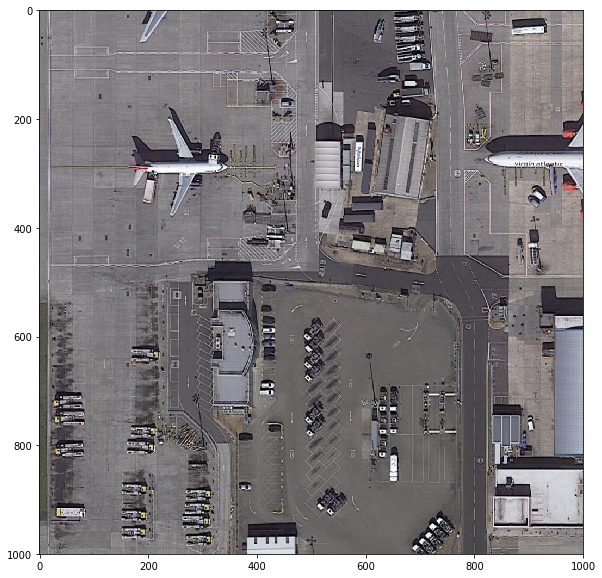

In [5]:
img_id = 25
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

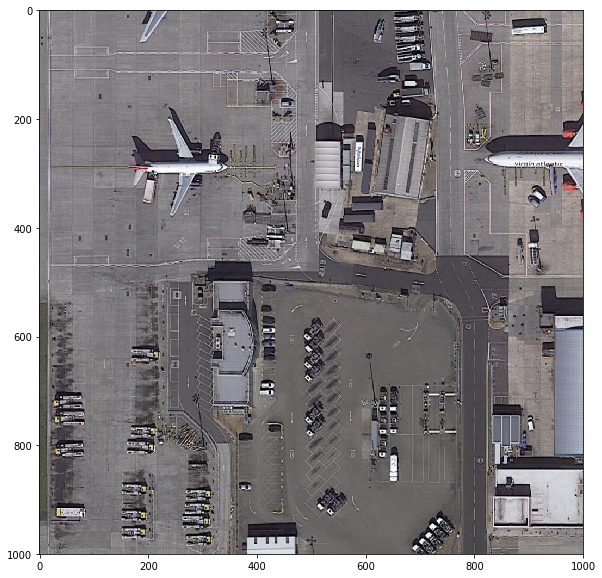

In [10]:
#image = cv2.imread('/home/buaab622/data/DOTA/train/images/P2790.png')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


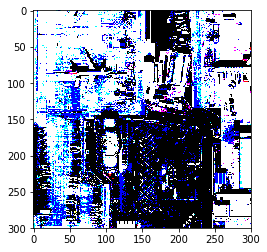

In [20]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [31]:
#
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
out = net(xx) #前向计算输出的特征向量
print('out = ',out[0].size(0))
#
boxes, scores = detector.forward(out,priors)
boxes = boxes[0]
scores = scores[0]
scale = torch.Tensor([image.shape[1], image.shape[0],image.shape[1], image.shape[0]])
if torch.cuda.is_available():
    scale = scale.cuda()
boxes *= scale
# 放入CPU，便于后续NMS
boxes = boxes.cpu().numpy()
scores = scores.cpu().numpy()

#
all_boxes = [[[] for _ in range(num_images)]for _ in range(num_classes)]
i=0
for j in range(1, num_classes):
    inds = np.where(scores[:, j] > thresh)[0]
    if len(inds) == 0:
        all_boxes[j][i] = np.empty([0, 5], dtype=np.float32)
        continue
    c_bboxes = boxes[inds]
    c_scores = scores[inds, j]
    c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(np.float32, copy=False)
    
    keep = nms(c_dets, 0.45, force_cpu=True) # 非极大抑制
    c_dets = c_dets[keep, :]
    all_boxes[j][i] = c_dets
if max_per_image > 0:
    image_scores = np.hstack([all_boxes[j][i][:, -1] for j in range(1,num_classes)]) #取出当前图像上非极大抑制后留下的所有框的置信度信息
    if len(image_scores) > max_per_image:
        image_thresh = np.sort(image_scores)[-max_per_image] #挑选出置信度阈值
        for j in range(1, num_classes):
            keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0] #挑选出置信度排名前max_per_image的预测框
            all_boxes[j][i] = all_boxes[j][i][keep, :]
# all_boxes 所有框
# all_boxes[num_class][num_image][num_box]
# box = [4个位置信息，1个置信度]
print((all_boxes[1][0][0]))

out =  1
[149.628     179.16861   359.75693   394.15384     0.9997502]


image size is: (1000, 1000, 3)
(83, 5)
the number of boxes:  83 label: plane
[149.628     179.16861   359.75693   394.15384     0.9997502]
[7.9431531e+02 8.1309883e+01 9.9494360e+02 4.7644214e+02 1.7392243e-01]


/home/buaab622/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


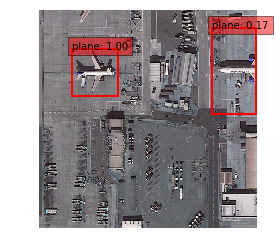

In [39]:
# 可视化
print('image size is:',image.shape)
plt.imshow(image)
plt.axis('off')
ax = plt.gca()
ax.set_autoscale_on(False)
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0) # 调整显示图像大小
polygons = []
color = []
circles = []
currentAxis = plt.gca()
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for k in range(1, num_classes):
    dets = all_boxes[k][i] # 一个种类的所有水平框
    print(dets.shape)
    if dets == []:
        continue
    print('the number of boxes: ', dets.shape[0], 'label:', DOTA_CLASSES[k])
    for s in range(dets.shape[0]): # 遍历所有框
        if dets[s][-1] >= 0.1:
            print (dets[s])
            c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] # 随机选颜色
            #color.append(c)
            """
            xc,yc,w,h = dets[s][:4]
            xmin = xc - w/2
            xmax = xc + w/2
            ymin = yc - h/2
            ymax = yc + h/2
            """
            xmin,ymin,xmax,ymax = dets[s][:4]
            if xmin < 0: xmin =0
            if ymin < 0: ymin =0
            if xmax > image.shape[0]: xmax = image.shape[0]
            if ymax > image.shape[0]: ymax = image.shape[1]
            #poly = [(xmin,ymax),(xmin,ymin),(xmax,ymin),(xmax,ymax)]
            #polygons.append(Polygon(poly)) #append应该是允许多次画框
            # 标签
            #text = DOTA_CLASSES[k]+ ':' + '{:.3f}'.format(dets[s, -1])
            #cv2.rectangle(img, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), (int(dets[s, 2] + 1),int(dets[s, 3] + 1)), colors[k], 2)
            #cv2.putText(img, text, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[k], 1)
            display_txt = '%s: %.2f'%(DOTA_CLASSES[k], dets[s, -1])
            pt = dets[s][:4]
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        
#p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
#ax.add_collection(p)
#p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
#ax.add_collection(p)

image size is: (500, 500, 3)
(57, 5)
the number of boxes:  57 label: ship
(83, 5)
the number of boxes:  83 label: small-vehicle
[2.4298367e+01 1.8061009e+02 4.1019203e+01 2.1553224e+02 1.7145711e-01]
[4.1887341e+00 1.8101114e+02 2.0438448e+01 2.1834822e+02 1.5147299e-01]


/home/buaab622/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


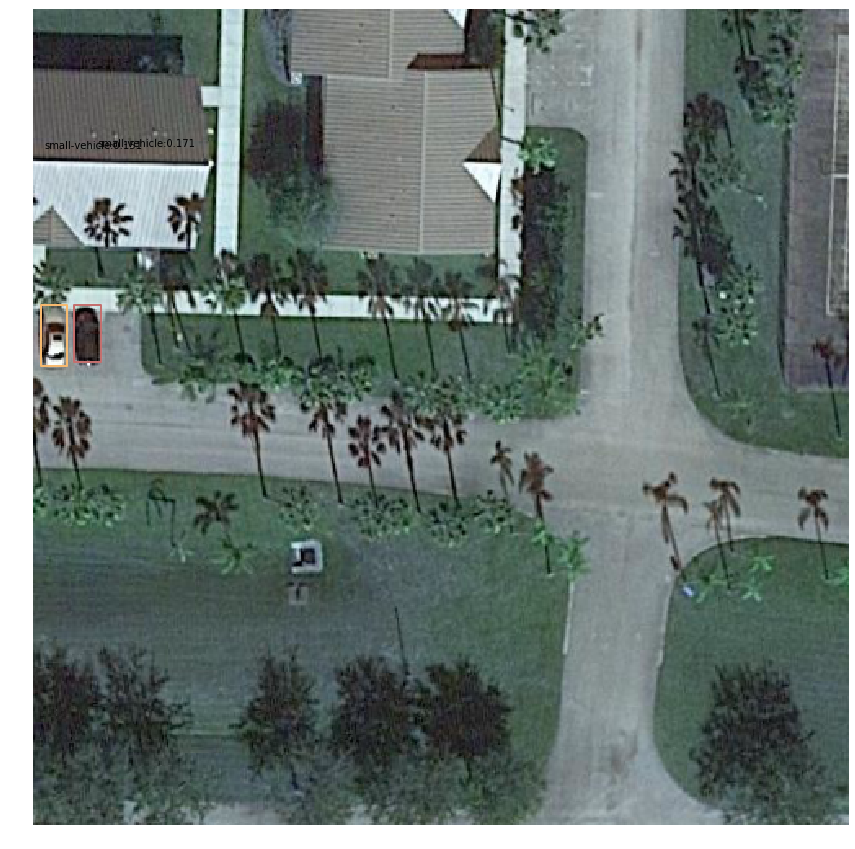

In [70]:
# 可视化
print('image size is:',image.shape)
plt.imshow(image)
plt.axis('off')
ax = plt.gca()
ax.set_autoscale_on(False)
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0) # 调整显示图像大小
polygons = []
color = []
circles = []
colors = [(0,0,0),(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128),(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0),(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128),(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
for k in range(1, num_classes):
    dets = all_boxes[k][i] # 一个种类的所有水平框
    print(dets.shape)
    if dets == []:
        continue
    print('the number of boxes: ', dets.shape[0], 'label:', DOTA_CLASSES[k])
    for s in range(dets.shape[0]): # 遍历所有框
        if dets[s][-1] >= 0.06:
            print (dets[s])
            c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] # 随机选颜色
            color.append(c)
            """
            xc,yc,w,h = dets[s][:4]
            xmin = xc - w/2
            xmax = xc + w/2
            ymin = yc - h/2
            ymax = yc + h/2
            """
            xmin,ymin,xmax,ymax = dets[s][:4]
            if xmin < 0: xmin =0
            if ymin < 0: ymin =0
            if xmax > image.shape[0]: xmax = image.shape[0]
            if ymax > image.shape[0]: ymax = image.shape[1]
            poly = [(xmin,ymax),(xmin,ymin),(xmax,ymin),(xmax,ymax)]
            polygons.append(Polygon(poly)) #append应该是允许多次画框
            # 标签
            text = DOTA_CLASSES[k]+ ':' + '{:.3f}'.format(dets[s, -1])
            #cv2.rectangle(img, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), (int(dets[s, 2] + 1),int(dets[s, 3] + 1)), colors[k], 2)
            #cv2.putText(img, text, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[k], 1)
            plt.annotate(text, xy=(int(xmin),int(ymax)),xytext=(int(xmin),int(ymax)), textcoords='offset points')
#p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
#ax.add_collection(p)
p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
ax.add_collection(p)

In [7]:
import cv2
cv2.__version__

'3.4.2'

In [38]:
loc_3 = torch.Tensor(1,11620,4)
a = loc_3[:,-1]
a.size()

torch.Size([1, 4])